In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from tensorflow.data import Dataset
import pandas as pd
import numpy as np
import itertools
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv('new_way.csv')
df['action'].count()

412

In [17]:
x = df.drop('action',axis=1)
y = df.action

In [18]:
lb = LabelEncoder()
y = lb.fit_transform(y)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, stratify = y)

In [20]:
model = Sequential([
    Input(shape=(15)),
    Dense(5, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 5)                 80        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(
    x_train,
    y_train,
    steps_per_epoch = 5,
    epochs = 40,
    validation_data = (x_test, y_test),
    verbose=1
)

Epoch 1/40
1/5 [=====>........................] - ETA: 1s - loss: 199.3792 - accuracy: 0.3636

2022-11-20 14:39:34.303722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 63ms/step - loss: 206.0539 - accuracy: 0.3739 - val_loss: 216.3593 - val_accuracy: 0.3735
Epoch 2/40
5/5 [==============================] - 0s 15ms/step - loss: 192.2377 - accuracy: 0.3739 - val_loss: 201.8737 - val_accuracy: 0.3735
Epoch 3/40
1/5 [=====>........................] - ETA: 0s - loss: 168.3318 - accuracy: 0.4697

2022-11-20 14:39:34.586982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 15ms/step - loss: 178.3235 - accuracy: 0.3739 - val_loss: 187.9454 - val_accuracy: 0.3735
Epoch 4/40
5/5 [==============================] - 0s 15ms/step - loss: 164.8819 - accuracy: 0.3739 - val_loss: 174.7115 - val_accuracy: 0.3735
Epoch 5/40
5/5 [==============================] - 0s 16ms/step - loss: 152.6269 - accuracy: 0.3739 - val_loss: 161.4497 - val_accuracy: 0.3735
Epoch 6/40
5/5 [==============================] - 0s 16ms/step - loss: 139.5832 - accuracy: 0.3739 - val_loss: 148.4756 - val_accuracy: 0.3735
Epoch 7/40
5/5 [==============================] - 0s 17ms/step - loss: 127.3113 - accuracy: 0.3739 - val_loss: 135.4971 - val_accuracy: 0.3735
Epoch 8/40
5/5 [==============================] - 0s 16ms/step - loss: 115.3756 - accuracy: 0.3739 - val_loss: 122.4518 - val_accuracy: 0.3735
Epoch 9/40
5/5 [==============================] - 0s 16ms/step - loss: 102.3466 - accuracy: 0.3739 - val_loss: 109.7430 - val_accuracy: 0.3735
Epoch 10/4

In [23]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

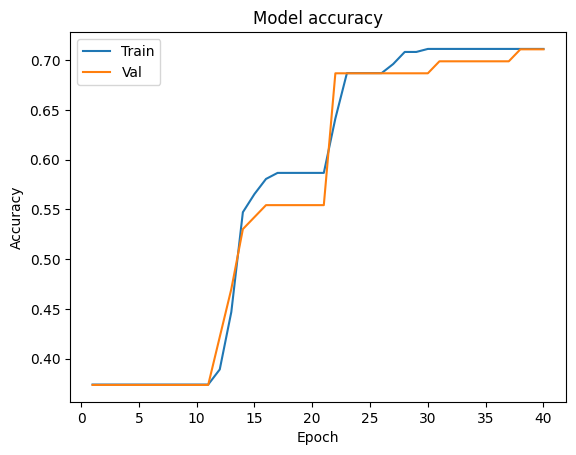

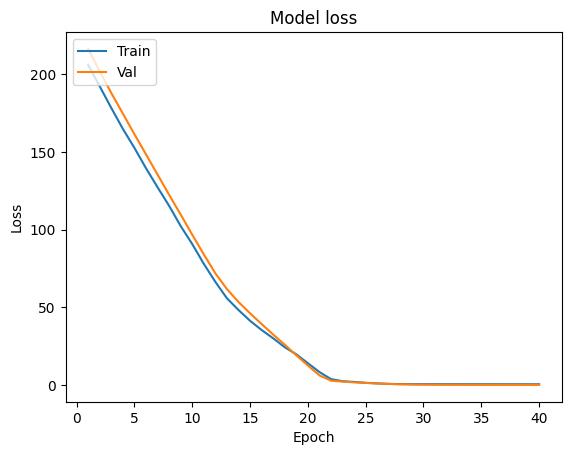

In [24]:
plot_learningCurve(history, 40)

In [30]:
test_X = np.array([
    [1321.889771,1054.833008,1278.117920,-317.187561,-117.191925,643.934631,-293.195221,-117.276314,747.565552,-186.781418,57.922749,831.953430,421.568390,282.367767,645.893616],
    [-370.724579,-181.217148,70.977104,680.856384,244.135330,425.930145,660.864990,252.465317,420.329529,582.291016,273.523987,348.257385,418.830933,280.534210,641.699524],
    [1174.421509,811.148682,1237.666992,-340.420105,-245.926758,529.321777,-366.678040,-255.753250,494.149170,418.830933,280.534210,641.699524,418.830933,280.534210,641.699524],
    [615.333618,427.486267,789.206970,328.846710,47.515835,485.224457,283.617737,39.852085,444.249359,421.568390,282.367767,645.893616,421.568390,282.367767,645.893616],
    [421.568390,282.367767,645.893616,761.635010,301.182281,498.242401,711.948303,304.129578,468.107452,421.568390,282.367767,645.893616,421.568390,282.367767,645.893616],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
])
Y = model.predict_on_batch(test_X)
print(Y)

[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.55136794]]


In [26]:
test_X = np.array([
    [-371.472626,-270.972260,-142.165512,-33.497070,-232.640335,-80.189026,160.922134,-66.725060,54.446323,238.968887,23.842035,79.471870,418.830933,280.534210,641.699524],
])
Y = model.predict(test_X)
print(Y)

1/1 [==============================] - 0s 40ms/step
[[1.]]


2022-11-20 14:39:43.553332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [27]:
test_X = np.array([
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
])
Y = model.predict(test_X)
print(Y)

1/1 [==============================] - 0s 44ms/step
[[0.55136794]]


2022-11-20 14:39:44.858905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
    for _ in range(10000):
        yield [
            np.array(
                [np.random.uniform(), np.random.uniform()]
            , dtype=np.float32)
        ]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_quant_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: /var/folders/fx/5gyl_pgs2094_xlx9szcscp00000gn/T/tmplyd8th1f/assets


/Users/csabakoos/miniforge3/envs/tf/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-11-20 14:42:30.259587: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-20 14:42:30.259602: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-20 14:42:30.260136: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/fx/5gyl_pgs2094_xlx9szcscp00000gn/T/tmplyd8th1f
2022-11-20 14:42:30.260878: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-20 14:42:30.260886: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/fx/5gyl_pgs2094_xlx9szcscp00000gn/T/tmplyd8th1f
2022-11-20 14:42:30.2

2020

In [ ]:
# xxd -i converted_model.tflite > model_data.cc